In [ ]:
########################################################
# TODO
# - https://stackoverflow.com/questions/55314345/how-to-find-feature-importance-or-variable-importance-graph-for-knnclassifier
########################################################

# Location Classification
The goal of this notebook is to find important lab tests per location of (positive) uveitis patients. 
The hypothesis is that an anterior inflammation can be identified by a different subset of lab tests as for example posterior inflammations. 
This would allow to order a subset of all possible lab tests after the location of the inflammation has been located to identify uveitis. One approach would be to train a model per location.

Steps:

1. Get Subset of Data (Target Featue: Location, Input Features: Lab Results) 
2. Define suitable Algorithms for Binary Classification (e.g. Logistic Regression, etc.)
3. Call preprocessing pipe with appropriat parameters for the current algorithm
4. Fit Model
5. Extract and Discuss important Features

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn standard imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Binarizer, LabelEncoder, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# !pip install scikit-optimize # = skopt
from skopt import BayesSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score, precision_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from dtreeviz.trees import dtreeviz
from sklearn.metrics import plot_confusion_matrix


# import of pipe module
os.chdir('../preprocessing/')
import pipe

os.chdir('../machine_learning/')
import helpers


RANDOM = 43
SCORER = make_scorer(f1_score, average='macro')
def SCORE(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [2]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'multi',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

,gender,loc,calcium,lactate_dehydrogenase,"c-reactive_protein,_normal_and_high_sensitivity",wbc,rbc,hemoglobin,hematocrit,mcv,...,"lysozyme,_plasma",anti-ccp_ab,anti-ena_screen,antinuclear_antibody,dna_double-stranded_ab,rheumatoid_factor,hbc__ab,hbs__ag,hcv__ab,uveitis
0,Male,anterior,2.27,184,1.83,6.91,4.97,14.6,41.4,83.3,...,3.0,0.0,0.0,0.0,0.0,0,0,0,0,False
1,Female,intermediate,2.32,209,0.15,4.24,4.22,11.0,36.0,85.3,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
2,Female,panuveitis,2.44,194,0.137,6.38,4.31,13.6,38.7,89.8,...,4.8,0.0,0.0,0.0,0.0,0,0,0,0,True
3,Female,anterior,2.45,156,3.5,5.24,4.82,14.6,43.6,90.5,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
4,Female,anterior,2.28,175,1.0,8.31,4.72,14.0,40.7,86.2,...,4.5,0.0,0.0,0.0,1.0,0,0,0,0,True


### Split into uveitis and not_uveitis data

In [3]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

# Multiclass classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the binary classification (see next chapter)

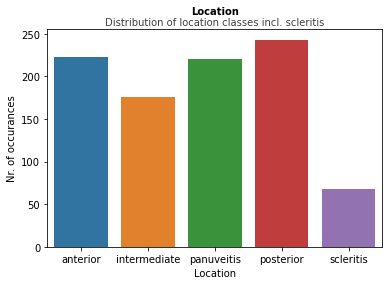

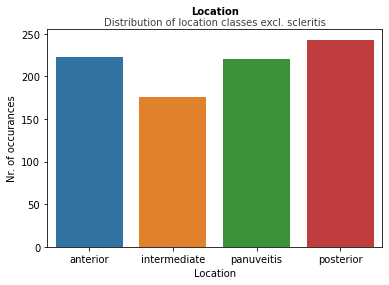

In [4]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['loc']) # drop records with missing location data (3)


g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes incl. scleritis','Location','Nr. of occurances')

# remove category scleritis
df_uv_pos_clean = df_uv_pos_clean[df_uv_pos_clean['loc'] != 'scleritis']
df_uv_pos_clean['loc'] = df_uv_pos_clean['loc'].cat.remove_unused_categories()

g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes excl. scleritis','Location','Nr. of occurances')

**Discussion** The target feature contains 5 classes. The three missing values have been removed. We can see that, with the execption of the location 'scleritis', that the classes are somewhat balanced. We remove the records with location 'scleritis' as upsampling or downsampling is not an option for this dataset. Because it is a minority class, it can negatively impact the prediction for every other class.

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

In [5]:
# train_test_split
X = df_uv_pos_clean.drop(columns=['loc','uveitis','gender'])
y = df_uv_pos_clean['loc']

X_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male'].drop(columns=['loc','uveitis','gender'])
X_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female'].drop(columns=['loc','uveitis','gender'])
y_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male']['loc']
y_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female']['loc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=RANDOM, stratify = y_m)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM, stratify = y_f)

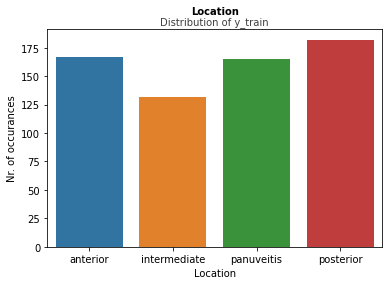

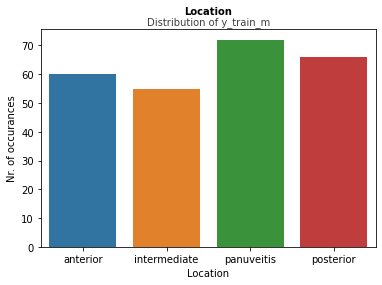

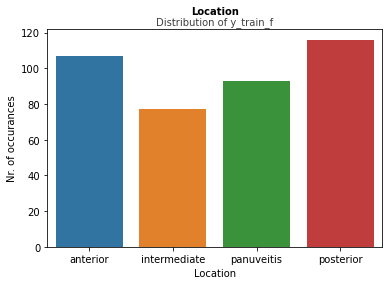

In [6]:
g = sns.countplot(x=y_train)
helpers.plot_wrapper(g, 'Location','Distribution of y_train','Location','Nr. of occurances')
g = sns.countplot(x=y_train_m)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_m','Location','Nr. of occurances')
g = sns.countplot(x=y_train_f)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_f','Location','Nr. of occurances')

#### Imputation and Encoding

In [7]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_onehot # imputer_encoder_onehot yields best results so far 

## Baseline Model
This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 
### Complete positive data

In [8]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Score Dummy Classifier: {SCORE(y_test, pipeline.predict(X_test))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.25
Class probabilites: [0.25851393 0.20433437 0.25541796 0.28173375]


### Male positive data

In [9]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_m, y_train_m)
print(f'Score Dummy Classifier: {SCORE(y_test_m, pipeline.predict(X_test_m))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.32941176470588235
Class probabilites: [0.23715415 0.2173913  0.28458498 0.26086957]


### Female positive data

In [10]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_f, y_train_f)
print(f'Score Dummy Classifier: {SCORE(y_test_f, pipeline.predict(X_test_f))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.2595419847328244
Class probabilites: [0.27226463 0.19592875 0.23664122 0.29516539]


## Decision Tree

### Complete positive data

Score: 0.2361111111111111
Best Parameters:
{'tree__class_weight': 'balanced', 'tree__criterion': 'gini', 'tree__max_depth': 18, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'random'}
              precision    recall  f1-score   support

    anterior       0.25      0.27      0.26        56
intermediate       0.20      0.20      0.20        44
  panuveitis       0.22      0.24      0.23        55
   posterior       0.27      0.23      0.25        61

    accuracy                           0.24       216
   macro avg       0.24      0.23      0.23       216
weighted avg       0.24      0.24      0.24       216



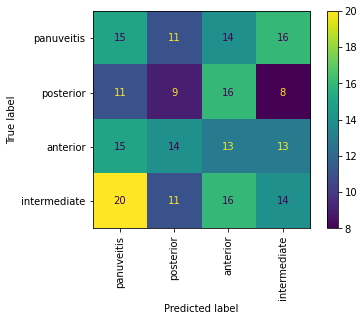

In [11]:
# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def dec_tree(X_train, X_test, y_train, y_test):
    dectree = DecisionTreeClassifier(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', dectree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__criterion':['gini','entropy'],
        'tree__splitter' :['best','random'],
        'tree__max_depth':np.arange(2,20,2),
        'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
        'tree__random_state':[RANDOM],
        'tree__class_weight':['balanced', None] # balanced = inverse proportional importance per class
    }

    # grid search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

dec_tree(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.25882352941176473
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'gini', 'tree__max_depth': 4, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'best'}
              precision    recall  f1-score   support

    anterior       0.23      0.45      0.30        20
intermediate       0.27      0.16      0.20        19
  panuveitis       0.31      0.21      0.25        24
   posterior       0.28      0.23      0.25        22

    accuracy                           0.26        85
   macro avg       0.27      0.26      0.25        85
weighted avg       0.27      0.26      0.25        85



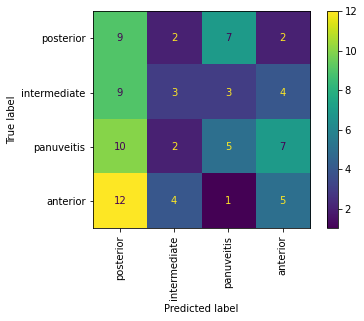

In [12]:
dec_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.25190839694656486
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'entropy', 'tree__max_depth': 16, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
              precision    recall  f1-score   support

    anterior       0.26      0.19      0.22        36
intermediate       0.17      0.12      0.14        25
  panuveitis       0.21      0.26      0.23        31
   posterior       0.31      0.38      0.34        39

    accuracy                           0.25       131
   macro avg       0.24      0.24      0.23       131
weighted avg       0.25      0.25      0.25       131



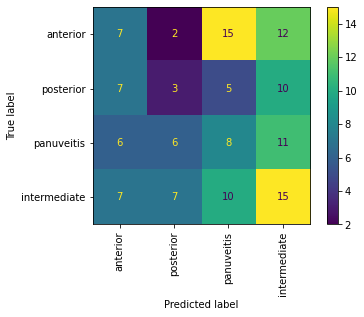

In [13]:
dec_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## Random Forest
### Complete positive data

Score: 0.28703703703703703
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.29      0.29      0.29        56
intermediate       0.32      0.20      0.25        44
  panuveitis       0.26      0.31      0.28        55
   posterior       0.30      0.33      0.31        61

    accuracy                           0.29       216
   macro avg       0.29      0.28      0.28       216
weighted avg       0.29      0.29      0.29       216



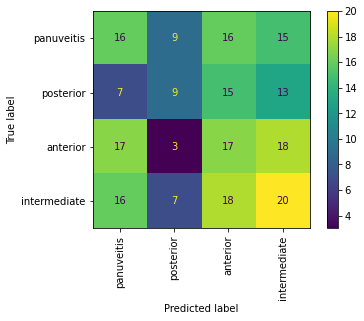

In [14]:
from sklearn.ensemble import RandomForestClassifier

def ran_tree(X_train, X_test, y_train, y_test):
    rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', rantree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__n_estimators':[100,1000],
        'tree__max_features':['log2', 'sqrt', 'auto'],
        'tree__oob_score':[True,False]
    }

    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv.best_estimator_, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
ran_tree(X_train, X_test, y_train, y_test)

In [15]:
# helpers.plot_validation_curve(bv.best_estimator_.fit(X_train, y_train), X_test, y_test, 'tree__n_estimators',np.arange(10,100,10), scorer)

### Male positive data

Score: 0.27058823529411763
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.25      0.15      0.19        20
intermediate       0.23      0.26      0.24        19
  panuveitis       0.29      0.33      0.31        24
   posterior       0.30      0.32      0.31        22

    accuracy                           0.27        85
   macro avg       0.27      0.27      0.26        85
weighted avg       0.27      0.27      0.27        85



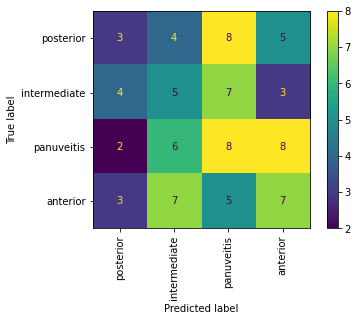

In [16]:
ran_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.31297709923664124
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 1000, 'tree__oob_score': True}
              precision    recall  f1-score   support

    anterior       0.28      0.25      0.26        36
intermediate       0.14      0.08      0.10        25
  panuveitis       0.29      0.26      0.27        31
   posterior       0.39      0.56      0.46        39

    accuracy                           0.31       131
   macro avg       0.27      0.29      0.27       131
weighted avg       0.29      0.31      0.29       131



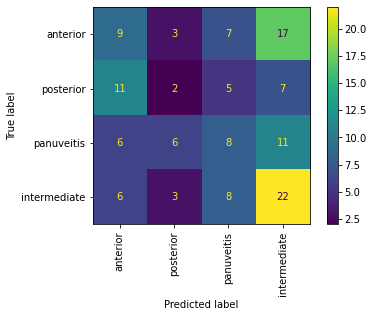

In [17]:
ran_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## KNN
### Complete positive data

Score: 0.25925925925925924
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

    anterior       0.21      0.20      0.20        56
intermediate       0.31      0.30      0.30        44
  panuveitis       0.26      0.27      0.27        55
   posterior       0.27      0.28      0.27        61

    accuracy                           0.26       216
   macro avg       0.26      0.26      0.26       216
weighted avg       0.26      0.26      0.26       216



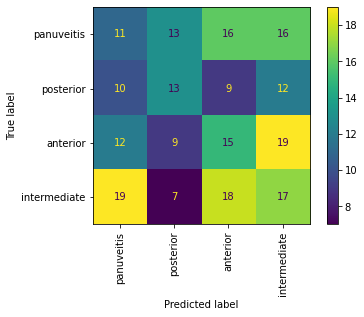

In [18]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_jobs=-1)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('knn', knn)
    ])

    # hyperparameterspace
    parameters = {
        'knn__n_neighbors':np.arange(5,100,10),
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute']
    }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
knn_model(X_train, X_test, y_train, y_test)

### Male positive data 

Score: 0.2823529411764706
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
              precision    recall  f1-score   support

    anterior       0.18      0.15      0.16        20
intermediate       0.26      0.37      0.30        19
  panuveitis       0.36      0.42      0.38        24
   posterior       0.31      0.18      0.23        22

    accuracy                           0.28        85
   macro avg       0.28      0.28      0.27        85
weighted avg       0.28      0.28      0.27        85



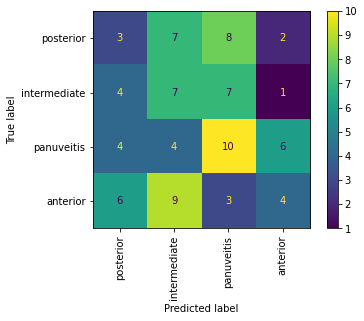

In [19]:
knn_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.3435114503816794
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 25, 'knn__weights': 'uniform'}
              precision    recall  f1-score   support

    anterior       0.29      0.47      0.36        36
intermediate       0.27      0.16      0.20        25
  panuveitis       0.40      0.19      0.26        31
   posterior       0.43      0.46      0.44        39

    accuracy                           0.34       131
   macro avg       0.35      0.32      0.32       131
weighted avg       0.35      0.34      0.33       131



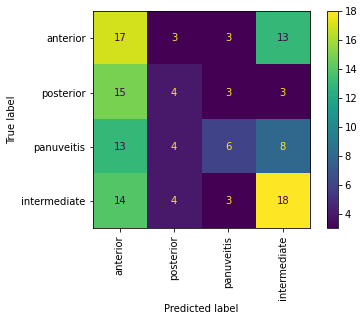

In [20]:
knn_model(X_train_f, X_test_f, y_train_f, y_test_f)

## SVM
### Complete positive data

Score: 0.2175925925925926
Best Parameters:
{'svc__C': 2.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

    anterior       0.18      0.12      0.15        56
intermediate       0.20      0.34      0.25        44
  panuveitis       0.20      0.20      0.20        55
   posterior       0.29      0.23      0.26        61

    accuracy                           0.22       216
   macro avg       0.22      0.22      0.21       216
weighted avg       0.22      0.22      0.21       216



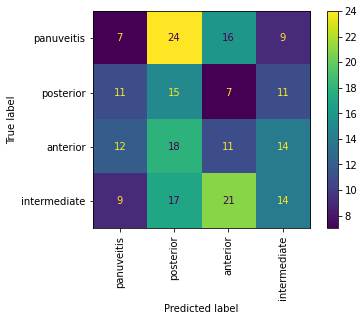

In [21]:
from sklearn.svm import SVC

def svc_model(X_train, X_test, y_train, y_test):
    svc = SVC(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('svc', svc)
    ])

    # hyperparameterspace
    parameters = {'svc__C':np.arange(0.1,3,.5),
                  'svc__kernel':['linear','poly','rbf','sigmoid'],
                  'svc__degree':np.arange(3,10,2), # used only for kernel = poly
                  'svc__class_weight':['balanced', None]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
svc_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.2823529411764706
Best Parameters:
{'svc__C': 1.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

    anterior       0.23      0.15      0.18        20
intermediate       0.25      0.47      0.33        19
  panuveitis       0.35      0.25      0.29        24
   posterior       0.32      0.27      0.29        22

    accuracy                           0.28        85
   macro avg       0.29      0.29      0.27        85
weighted avg       0.29      0.28      0.27        85



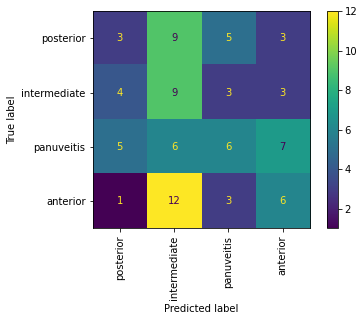

In [22]:
svc_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.2824427480916031
Best Parameters:
{'svc__C': 1.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'sigmoid'}
              precision    recall  f1-score   support

    anterior       0.28      0.25      0.26        36
intermediate       0.18      0.28      0.22        25
  panuveitis       0.25      0.23      0.24        31
   posterior       0.44      0.36      0.39        39

    accuracy                           0.28       131
   macro avg       0.29      0.28      0.28       131
weighted avg       0.30      0.28      0.29       131



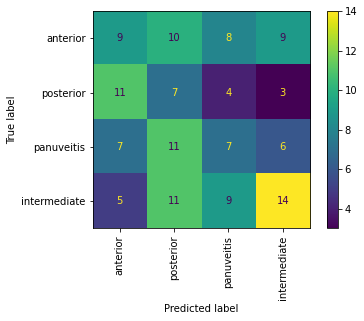

In [23]:
svc_model(X_train_f, X_test_f, y_train_f, y_test_f)

## MLP Classifier
### Complete positve data

Score: 0.32407407407407407
Best Parameters:
{'mlp__hidden_layer_sizes': (15, 10)}
              precision    recall  f1-score   support

    anterior       0.33      0.27      0.30        56
intermediate       0.30      0.36      0.33        44
  panuveitis       0.32      0.35      0.33        55
   posterior       0.34      0.33      0.33        61

    accuracy                           0.32       216
   macro avg       0.32      0.33      0.32       216
weighted avg       0.33      0.32      0.32       216



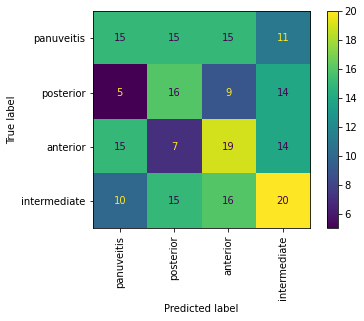

In [24]:
from sklearn.neural_network import MLPClassifier

def mlp_model(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('mlp', mlp)
    ])

    # hyperparameterspace
    parameters = {'mlp__hidden_layer_sizes':[(5,4),(5,5,4),(15,10),(20,20,10)]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
mlp_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.3058823529411765
Best Parameters:
{'mlp__hidden_layer_sizes': (15, 10)}
              precision    recall  f1-score   support

    anterior       0.38      0.25      0.30        20
intermediate       0.19      0.21      0.20        19
  panuveitis       0.42      0.42      0.42        24
   posterior       0.26      0.32      0.29        22

    accuracy                           0.31        85
   macro avg       0.31      0.30      0.30        85
weighted avg       0.32      0.31      0.31        85



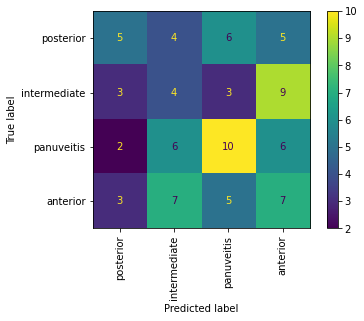

In [25]:
mlp_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.29770992366412213
Best Parameters:
{'mlp__hidden_layer_sizes': (15, 10)}
              precision    recall  f1-score   support

    anterior       0.38      0.33      0.35        36
intermediate       0.20      0.24      0.22        25
  panuveitis       0.22      0.13      0.16        31
   posterior       0.33      0.44      0.38        39

    accuracy                           0.30       131
   macro avg       0.28      0.28      0.28       131
weighted avg       0.29      0.30      0.29       131



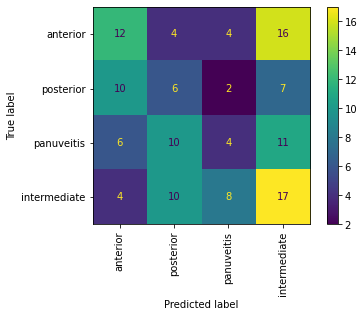

In [28]:
mlp_model(X_train_f, X_test_f, y_train_f, y_test_f)

## XGBoost
### Complete positve data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.3148148148148148
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 2, 'xgb__n_estimators': 20}
              precision    recall  f1-score   support

    anterior       0.36      0.38      0.37        56
intermediate       0.32      0.23      0.27        44
  panuveitis       0.25      0.29      0.27        55
   posterior       0.33      0.34      0.34        61

    accuracy                           0.31       216
   macro avg       0.32      0.31      0.31       216
weighted avg       0.32      0.31      0.31       216



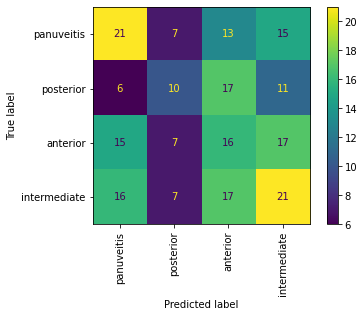

In [56]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
xgb_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.27058823529411763
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 7, 'xgb__n_estimators': 10}
              precision    recall  f1-score   support

    anterior       0.27      0.15      0.19        20
intermediate       0.25      0.26      0.26        19
  panuveitis       0.26      0.33      0.29        24
   posterior       0.30      0.32      0.31        22

    accuracy                           0.27        85
   macro avg       0.27      0.27      0.26        85
weighted avg       0.27      0.27      0.27        85



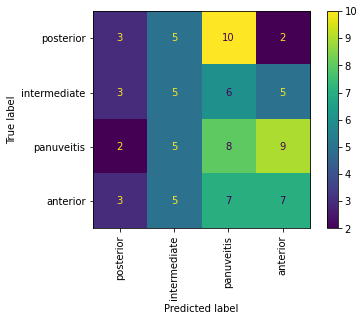

In [57]:
xgb_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.26717557251908397
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 5, 'xgb__n_estimators': 15}
              precision    recall  f1-score   support

    anterior       0.26      0.28      0.27        36
intermediate       0.19      0.12      0.15        25
  panuveitis       0.15      0.13      0.14        31
   posterior       0.37      0.46      0.41        39

    accuracy                           0.27       131
   macro avg       0.24      0.25      0.24       131
weighted avg       0.25      0.27      0.26       131



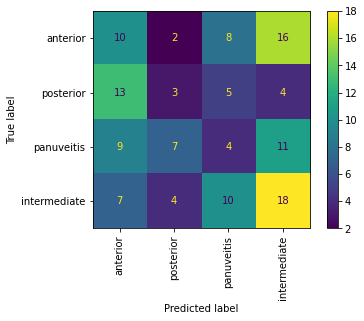

In [58]:
xgb_model(X_train_f, X_test_f, y_train_f, y_test_f)

## AdaBoost
### Complete positve data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.2361111111111111
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 14, 'ada__base_estimator__min_samples_split': 2, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 25}
              precision    recall  f1-score   support

    anterior       0.24      0.25      0.25        56
intermediate       0.15      0.09      0.11        44
  panuveitis       0.20      0.25      0.23        55
   posterior       0.31      0.31      0.31        61

    accuracy                           0.24       216
   macro avg       0.22      0.23      0.22       216
weighted avg       0.23      0.24      0.23       216



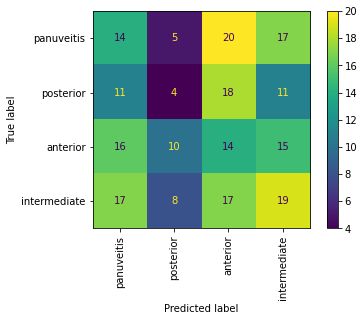

In [69]:
from sklearn.ensemble import AdaBoostClassifier

def ada_model(X_train, X_test, y_train, y_test):
    base_estimator = DecisionTreeClassifier(random_state=RANDOM)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM)

    pipeline = Pipeline(steps=[
                ('prep', USE_IMPUTER),
                ('ada', ada)
            ])

    params = {'ada__base_estimator__criterion':['gini','entropy'],
            'ada__base_estimator__splitter' :['best','random'],
            'ada__base_estimator__max_depth':np.arange(2,20,2),
            'ada__base_estimator__min_samples_split':[int(i) for i in np.arange(2,20,10)],
            'ada__base_estimator__random_state':[RANDOM],
            'ada__base_estimator__class_weight':['balanced', None],
            'ada__n_estimators':[10,25,50]}

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
ada_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.3058823529411765
Best Parameters:
{'ada__base_estimator__class_weight': None, 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 10, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 25}
              precision    recall  f1-score   support

    anterior       0.21      0.20      0.21        20
intermediate       0.22      0.11      0.14        19
  panuveitis       0.29      0.42      0.34        24
   posterior       0.45      0.45      0.45        22

    accuracy                           0.31        85
   macro avg       0.29      0.29      0.29        85
weighted avg       0.30      0.31      0.29        85



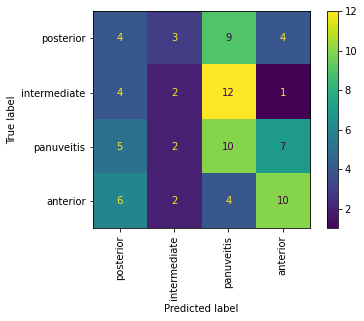

In [70]:
ada_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.2900763358778626
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 10, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'best', 'ada__n_estimators': 25}
              precision    recall  f1-score   support

    anterior       0.26      0.25      0.25        36
intermediate       0.19      0.16      0.17        25
  panuveitis       0.35      0.29      0.32        31
   posterior       0.33      0.41      0.36        39

    accuracy                           0.29       131
   macro avg       0.28      0.28      0.28       131
weighted avg       0.29      0.29      0.29       131



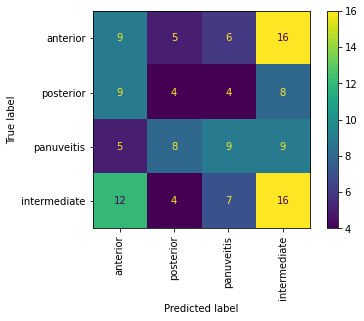

In [71]:
ada_model(X_train_f, X_test_f, y_train_f, y_test_f)

# Binary classification
In this section we try to predict the location of an inflammation of uveitis positive patients. For this we remove records of non uveitis patients.
These models can be used as a comparison for the mulitclass classification (see chapter above)

## Data Preparation
To predict the location of an inflammation, we need to drop all columns that contain information about the location. Meta-Information about the patient will also be dropped.

In [72]:
# calling preprocessing function

# num_to_cat = True: Range Date is now dtype Category 
# drop_filter: Drop every column that is not a lab test

df = pipe.preprocessing_pipe(num_to_cat   = False,
                             drop_filter  = ['hla', 'ac_', 'vit_','race', 'cat','specific_diagnosis'],
                             loc_approach = 'binary',
                             binary_cat   = True,
                             nan_percentage = 0.2,
                             hot_encode_cat = True) 
df.head()

,gender,loc,calcium,lactate_dehydrogenase,"c-reactive_protein,_normal_and_high_sensitivity",wbc,rbc,hemoglobin,hematocrit,mcv,...,"lysozyme,_plasma",anti-ccp_ab,anti-ena_screen,antinuclear_antibody,dna_double-stranded_ab,rheumatoid_factor,hbc__ab,hbs__ag,hcv__ab,uveitis
0,Male,anterior_segment,2.27,184,1.83,6.91,4.97,14.6,41.4,83.3,...,3.0,0.0,0.0,0.0,0.0,0,0,0,0,False
1,Female,posterior_segment,2.32,209,0.15,4.24,4.22,11.0,36.0,85.3,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
2,Female,posterior_segment,2.44,194,0.137,6.38,4.31,13.6,38.7,89.8,...,4.8,0.0,0.0,0.0,0.0,0,0,0,0,True
3,Female,anterior_segment,2.45,156,3.5,5.24,4.82,14.6,43.6,90.5,...,<NA>,0.0,0.0,0.0,0.0,0,0,0,0,True
4,Female,anterior_segment,2.28,175,1.0,8.31,4.72,14.0,40.7,86.2,...,4.5,0.0,0.0,0.0,1.0,0,0,0,0,True


### Split into uveitis and not_uveitis data

In [73]:
df_uv_pos = df[df.uveitis == True]
df_uv_neg = df[df.uveitis != True]

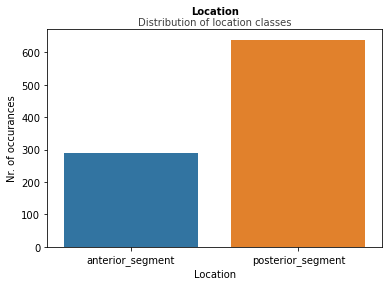

In [74]:
df_uv_pos_clean = df_uv_pos.dropna(subset=['loc']) # drop records with missing location data (3)


g = sns.countplot(x=df_uv_pos_clean['loc'])
helpers.plot_wrapper(g, 'Location','Distribution of location classes','Location','Nr. of occurances')

#### Train-Test Split
Trainingset contains 75% of data. The target feature is the loc (Location)-Feature. 
The target feature contains 3 missing values. We initially drop these records.

In [75]:
# train_test_split
X = df_uv_pos_clean.drop(columns=['loc','uveitis','gender'])
y = df_uv_pos_clean['loc']

X_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male'].drop(columns=['loc','uveitis','gender'])
X_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female'].drop(columns=['loc','uveitis','gender'])
y_m = df_uv_pos_clean[df_uv_pos_clean.gender == 'Male']['loc']
y_f = df_uv_pos_clean[df_uv_pos_clean.gender == 'Female']['loc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM, stratify = y)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.25, random_state=RANDOM, stratify = y_m)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.25, random_state=RANDOM, stratify = y_f)

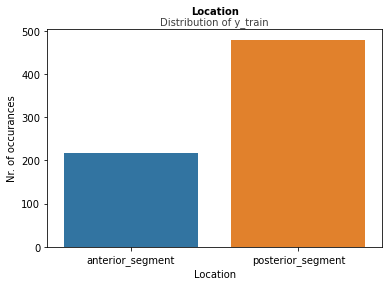

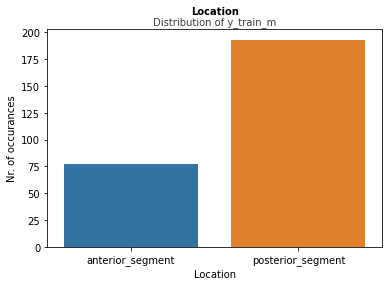

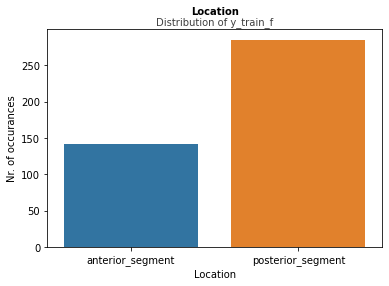

In [76]:
g = sns.countplot(x=y_train)
helpers.plot_wrapper(g, 'Location','Distribution of y_train','Location','Nr. of occurances')
g = sns.countplot(x=y_train_m)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_m','Location','Nr. of occurances')
g = sns.countplot(x=y_train_f)
helpers.plot_wrapper(g, 'Location','Distribution of y_train_f','Location','Nr. of occurances')

#### Imputation and Encoding

In [77]:
# filter for numeric and categorical features
numerics = ['Int64','float64']
category = ['category','bool']

# select list of numeric and categorical features
numeric_features = X.select_dtypes(include=numerics).columns.tolist()
categorical_features = X.select_dtypes(include=category).columns.tolist()

# define imputer strategy (consult sklarn SimpleImputer and StandardScaler documentation for options)
imputer = {'categorical':{'strategy':'most_frequent','fill_value':'most_frequent'}, 'numerical':{'strategy':'median', 'fill_value':'mean'}}
imputer_encoder_no_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False)
imputer_encoder_onehot = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=True, knn_impute=True)
imputer_encoder_no_onehot_knn = pipe.impute_and_encode(categorical_features, numeric_features, imputer, one_hot=False, knn_impute=True)

USE_IMPUTER = imputer_encoder_onehot # imputer_encoder_onehot yields best results so far 

## Baseline Model
This model acts as our basline. This model takes in the prior probability of a class occuring in the trainingset, and recommends blindly based on these probabilites. 
### Complete positive data

In [78]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train, y_train)
print(f'Score Dummy Classifier: {SCORE(y_test, pipeline.predict(X_test))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.5579399141630901
Class probabilites: [0.31276901 0.68723099]


### Male positive data

In [79]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_m, y_train_m)
print(f'Score Dummy Classifier: {SCORE(y_test_m, pipeline.predict(X_test_m))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.6043956043956044
Class probabilites: [0.28518519 0.71481481]


### Female positive data

In [80]:
dummy = DummyClassifier(strategy='stratified', random_state=RANDOM)
pipeline = Pipeline(steps=[('preprocessor', USE_IMPUTER),
                      ('classifier', dummy)])
pipeline.fit(X_train_f, y_train_f)
print(f'Score Dummy Classifier: {SCORE(y_test_f, pipeline.predict(X_test_f))}')
print(f'Class probabilites: {pipeline["classifier"].class_prior_}')

Score Dummy Classifier: 0.6083916083916084
Class probabilites: [0.33098592 0.66901408]


## Decision Tree

### Complete positive data

Score: 0.6866952789699571
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'gini', 'tree__max_depth': 10, 'tree__min_samples_split': 12, 'tree__random_state': 43, 'tree__splitter': 'random'}
                   precision    recall  f1-score   support

 anterior_segment       0.50      0.27      0.35        73
posterior_segment       0.73      0.88      0.79       160

         accuracy                           0.69       233
        macro avg       0.61      0.57      0.57       233
     weighted avg       0.65      0.69      0.66       233



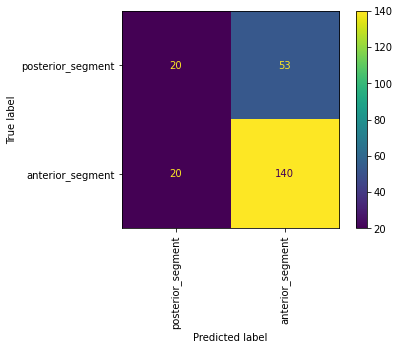

In [81]:
# supress warnings of estimator fit failed
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def dec_tree(X_train, X_test, y_train, y_test):
    dectree = DecisionTreeClassifier(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', dectree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__criterion':['gini','entropy'],
        'tree__splitter' :['best','random'],
        'tree__max_depth':np.arange(2,20,2),
        'tree__min_samples_split':[int(i) for i in np.arange(2,20,10)],
        'tree__random_state':[RANDOM],
        'tree__class_weight':['balanced', None] # balanced = inverse proportional importance per class
    }

    # grid search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');

dec_tree(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.7252747252747253
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'entropy', 'tree__max_depth': 10, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'best'}
                   precision    recall  f1-score   support

 anterior_segment       0.52      0.42      0.47        26
posterior_segment       0.79      0.85      0.81        65

         accuracy                           0.73        91
        macro avg       0.65      0.63      0.64        91
     weighted avg       0.71      0.73      0.72        91



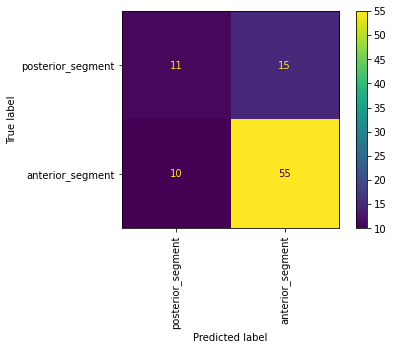

In [82]:
dec_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.6363636363636364
Best Parameters:
{'tree__class_weight': None, 'tree__criterion': 'entropy', 'tree__max_depth': 14, 'tree__min_samples_split': 2, 'tree__random_state': 43, 'tree__splitter': 'random'}
                   precision    recall  f1-score   support

 anterior_segment       0.44      0.36      0.40        47
posterior_segment       0.71      0.77      0.74        96

         accuracy                           0.64       143
        macro avg       0.57      0.57      0.57       143
     weighted avg       0.62      0.64      0.63       143



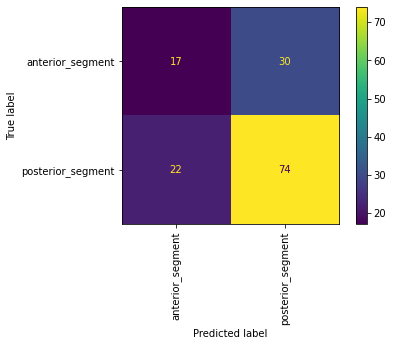

In [83]:
dec_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## Random Forest
### Complete positive data

Score: 0.6566523605150214
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 100, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.35      0.11      0.17        73
posterior_segment       0.69      0.91      0.78       160

         accuracy                           0.66       233
        macro avg       0.52      0.51      0.48       233
     weighted avg       0.58      0.66      0.59       233



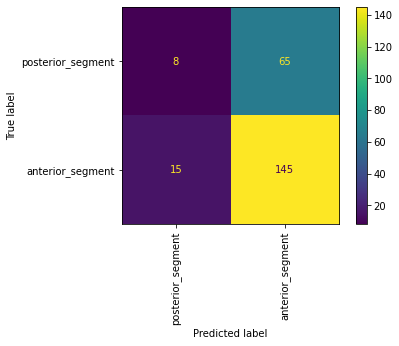

In [84]:
from sklearn.ensemble import RandomForestClassifier

def ran_tree(X_train, X_test, y_train, y_test):
    rantree = RandomForestClassifier(n_jobs=-1, random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('tree', rantree)
    ])

    # hyperparameterspace
    parameters = {
        'tree__n_estimators':[100,1000],
        'tree__max_features':['log2', 'sqrt', 'auto'],
        'tree__oob_score':[True,False]
    }

    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv.best_estimator_, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
ran_tree(X_train, X_test, y_train, y_test)

In [85]:
# helpers.plot_validation_curve(bv.best_estimator_.fit(X_train, y_train), X_test, y_test, 'tree__n_estimators',np.arange(10,100,10), scorer)

### Male positive data

Score: 0.6813186813186813
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 100, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.29      0.08      0.12        26
posterior_segment       0.71      0.92      0.81        65

         accuracy                           0.68        91
        macro avg       0.50      0.50      0.46        91
     weighted avg       0.59      0.68      0.61        91



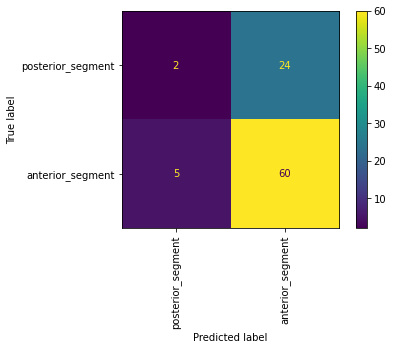

In [86]:
ran_tree(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.6433566433566433
Best Parameters:
{'tree__max_features': 'log2', 'tree__n_estimators': 100, 'tree__oob_score': True}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.13      0.19        47
posterior_segment       0.68      0.90      0.77        96

         accuracy                           0.64       143
        macro avg       0.53      0.51      0.48       143
     weighted avg       0.58      0.64      0.58       143



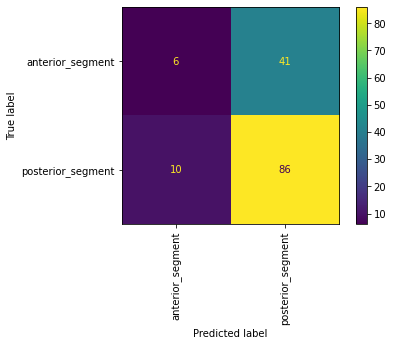

In [87]:
ran_tree(X_train_f, X_test_f, y_train_f, y_test_f)

## KNN
### Complete positive data

Score: 0.6909871244635193
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.52      0.15      0.23        73
posterior_segment       0.71      0.94      0.81       160

         accuracy                           0.69       233
        macro avg       0.62      0.54      0.52       233
     weighted avg       0.65      0.69      0.63       233



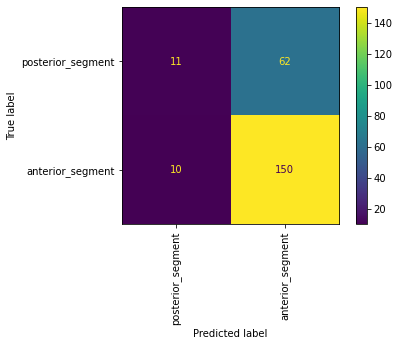

In [88]:
from sklearn.neighbors import KNeighborsClassifier

def knn_model(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier(n_jobs=-1)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('knn', knn)
    ])

    # hyperparameterspace
    parameters = {
        'knn__n_neighbors':np.arange(5,100,10),
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['auto','ball_tree','kd_tree','brute']
    }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
knn_model(X_train, X_test, y_train, y_test)

### Male positive data 

Score: 0.6593406593406593
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.35      0.23      0.28        26
posterior_segment       0.73      0.83      0.78        65

         accuracy                           0.66        91
        macro avg       0.54      0.53      0.53        91
     weighted avg       0.62      0.66      0.63        91



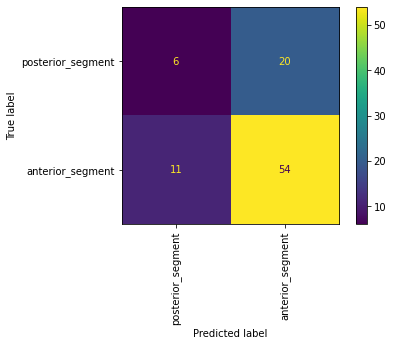

In [89]:
knn_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.6083916083916084
Best Parameters:
{'knn__algorithm': 'auto', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.30      0.33        47
posterior_segment       0.69      0.76      0.72        96

         accuracy                           0.61       143
        macro avg       0.53      0.53      0.53       143
     weighted avg       0.59      0.61      0.59       143



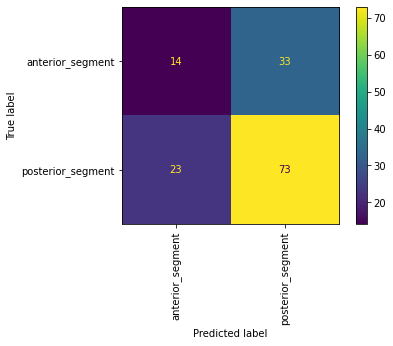

In [90]:
knn_model(X_train_f, X_test_f, y_train_f, y_test_f)

## SVM
### Complete positive data

Score: 0.5493562231759657
Best Parameters:
{'svc__C': 2.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
                   precision    recall  f1-score   support

 anterior_segment       0.30      0.34      0.32        73
posterior_segment       0.68      0.64      0.66       160

         accuracy                           0.55       233
        macro avg       0.49      0.49      0.49       233
     weighted avg       0.56      0.55      0.56       233



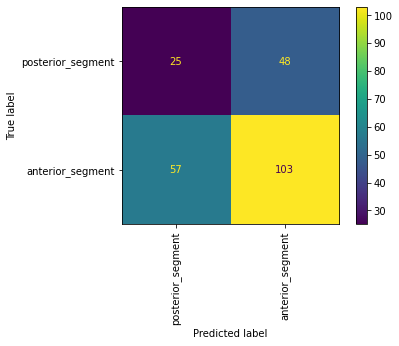

In [91]:
from sklearn.svm import SVC

def svc_model(X_train, X_test, y_train, y_test):
    svc = SVC(random_state=RANDOM)

    # without one_hot_encoded data
    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('svc', svc)
    ])

    # hyperparameterspace
    parameters = {'svc__C':np.arange(0.1,3,.5),
                  'svc__kernel':['linear','poly','rbf','sigmoid'],
                  'svc__degree':np.arange(3,10,2), # used only for kernel = poly
                  'svc__class_weight':['balanced', None]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
svc_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.5494505494505495
Best Parameters:
{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'linear'}
                   precision    recall  f1-score   support

 anterior_segment       0.33      0.54      0.41        26
posterior_segment       0.75      0.55      0.64        65

         accuracy                           0.55        91
        macro avg       0.54      0.55      0.52        91
     weighted avg       0.63      0.55      0.57        91



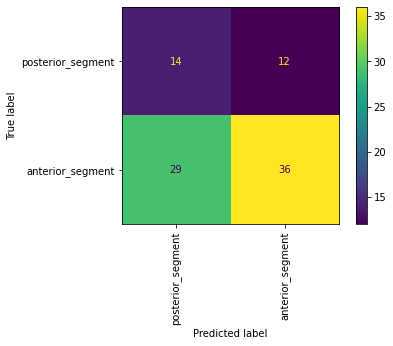

In [92]:
svc_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5524475524475524
Best Parameters:
{'svc__C': 2.6, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__kernel': 'rbf'}
                   precision    recall  f1-score   support

 anterior_segment       0.36      0.47      0.41        47
posterior_segment       0.70      0.59      0.64        96

         accuracy                           0.55       143
        macro avg       0.53      0.53      0.52       143
     weighted avg       0.59      0.55      0.56       143



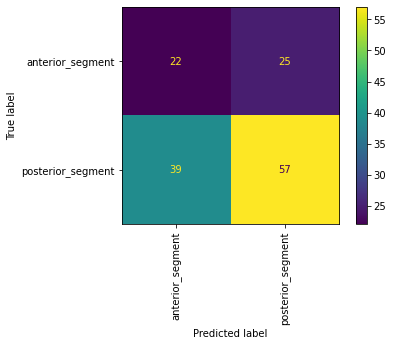

In [93]:
svc_model(X_train_f, X_test_f, y_train_f, y_test_f)

### MLP Classifier
#### Complete positve data

Score: 0.5836909871244635
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.31      0.26      0.28        73
posterior_segment       0.68      0.73      0.71       160

         accuracy                           0.58       233
        macro avg       0.50      0.50      0.49       233
     weighted avg       0.57      0.58      0.57       233



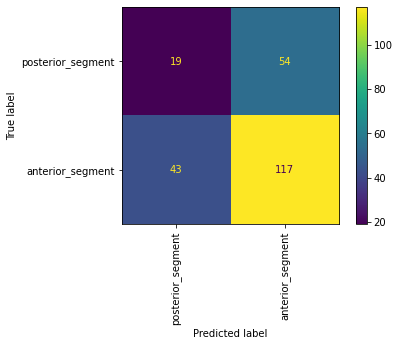

In [94]:
from sklearn.neural_network import MLPClassifier

def mlp_model(X_train, X_test, y_train, y_test):
    mlp = MLPClassifier(random_state=RANDOM)

    pipeline = Pipeline(steps=[
        ('prep', USE_IMPUTER),
        ('mlp', mlp)
    ])

    # hyperparameterspace
    parameters = {'mlp__hidden_layer_sizes':[(5,4),(5,5,4),(15,10),(20,20,10)]
                 }


    # bayes search
    bv = GridSearchCV(pipeline, parameters, cv = 3, scoring=SCORER)
    bv.fit(X_train, y_train)
    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
    
mlp_model(X_train, X_test, y_train, y_test)

### Male positive data

Score: 0.7252747252747253
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.53      0.35      0.42        26
posterior_segment       0.77      0.88      0.82        65

         accuracy                           0.73        91
        macro avg       0.65      0.61      0.62        91
     weighted avg       0.70      0.73      0.71        91



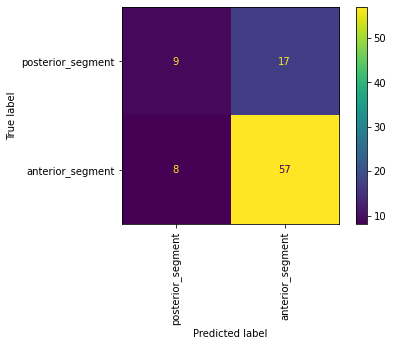

In [95]:
mlp_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Score: 0.5804195804195804
Best Parameters:
{'mlp__hidden_layer_sizes': (20, 20, 10)}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.43      0.40        47
posterior_segment       0.70      0.66      0.68        96

         accuracy                           0.58       143
        macro avg       0.54      0.54      0.54       143
     weighted avg       0.59      0.58      0.59       143



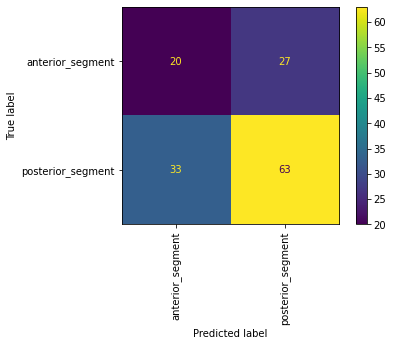

In [96]:
mlp_model(X_train_f, X_test_f, y_train_f, y_test_f)

## XGBoost

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.6609442060085837
Best Parameters:
{'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 5, 'xgb__n_estimators': 15}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.14      0.20        73
posterior_segment       0.70      0.90      0.78       160

         accuracy                           0.66       233
        macro avg       0.54      0.52      0.49       233
     weighted avg       0.60      0.66      0.60       233



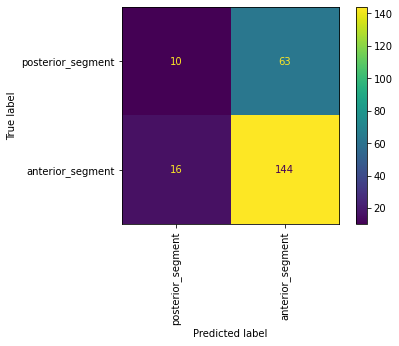

In [104]:
#!pip install xgboost
import xgboost as xgb

#dtrain_full = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
#dtest_full = xgb.DMatrix(data=X_test, label=y_test)

def xgb_model(X_train, X_test, y_train, y_test):
    params = {'xgb__colsample_bytree':[0.3,0.7,1],
             'xgb__max_depth':[2,5,7],
             'xgb__n_estimators':[10,15,20]}

    gbm = xgb.XGBClassifier(n_jobs=-1, objective='binary:logistic', random_state=RANDOM, verbosity=0)

    pipeline = Pipeline(steps=[
            ('prep', USE_IMPUTER),
            ('xgb', gbm)
        ])

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
xgb_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.6593406593406593
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 5, 'xgb__n_estimators': 20}
                   precision    recall  f1-score   support

 anterior_segment       0.35      0.23      0.28        26
posterior_segment       0.73      0.83      0.78        65

         accuracy                           0.66        91
        macro avg       0.54      0.53      0.53        91
     weighted avg       0.62      0.66      0.63        91



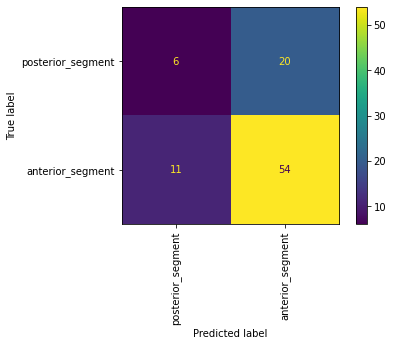

In [105]:
xgb_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Score: 0.6153846153846154
Best Parameters:
{'xgb__colsample_bytree': 1, 'xgb__max_depth': 7, 'xgb__n_estimators': 20}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.28      0.32        47
posterior_segment       0.69      0.78      0.73        96

         accuracy                           0.62       143
        macro avg       0.54      0.53      0.53       143
     weighted avg       0.59      0.62      0.60       143



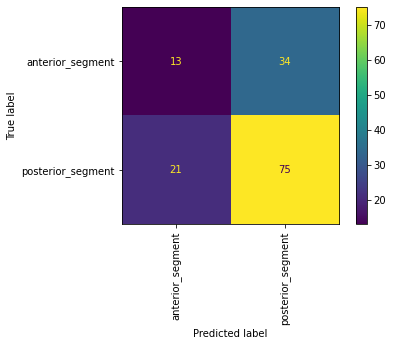

In [106]:
xgb_model(X_train_f, X_test_f, y_train_f, y_test_f)

## AdaBoost
### Complete positve data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.630901287553648
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 8, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 50}
                   precision    recall  f1-score   support

 anterior_segment       0.36      0.22      0.27        73
posterior_segment       0.70      0.82      0.75       160

         accuracy                           0.63       233
        macro avg       0.53      0.52      0.51       233
     weighted avg       0.59      0.63      0.60       233



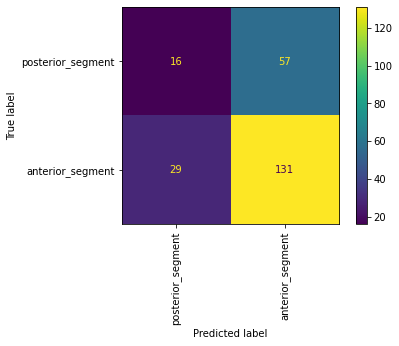

In [107]:
from sklearn.ensemble import AdaBoostClassifier

def ada_model(X_train, X_test, y_train, y_test):
    base_estimator = DecisionTreeClassifier(random_state=RANDOM)

    ada = AdaBoostClassifier(base_estimator=base_estimator, random_state=RANDOM)

    pipeline = Pipeline(steps=[
                ('prep', USE_IMPUTER),
                ('ada', ada)
            ])

    params = {'ada__base_estimator__criterion':['gini','entropy'],
            'ada__base_estimator__splitter' :['best','random'],
            'ada__base_estimator__max_depth':np.arange(2,20,2),
            'ada__base_estimator__min_samples_split':[int(i) for i in np.arange(2,20,10)],
            'ada__base_estimator__random_state':[RANDOM],
            'ada__base_estimator__class_weight':['balanced', None],
            'ada__n_estimators':[10,25,50]}

    bv = GridSearchCV(param_grid=params, estimator=pipeline,cv=3, verbose=1, scoring=SCORER)

    bv.fit(X_train, y_train)

    print(f'Score: {SCORE(y_test, bv.best_estimator_.predict(X_test))}')
    print('Best Parameters:')
    print(bv.best_params_)
    print(classification_report(y_test, bv.predict(X_test)))
    plot_confusion_matrix(bv, X_test, y_test, 
                          display_labels=y_test.unique(),
                          xticks_rotation='vertical');
ada_model(X_train, X_test, y_train, y_test)

### Male positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.6373626373626373
Best Parameters:
{'ada__base_estimator__class_weight': 'balanced', 'ada__base_estimator__criterion': 'gini', 'ada__base_estimator__max_depth': 6, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.38      0.42      0.40        26
posterior_segment       0.76      0.72      0.74        65

         accuracy                           0.64        91
        macro avg       0.57      0.57      0.57        91
     weighted avg       0.65      0.64      0.64        91



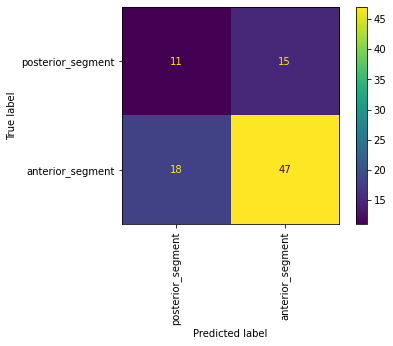

In [108]:
ada_model(X_train_m, X_test_m, y_train_m, y_test_m)

### Female positive data

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Score: 0.6293706293706294
Best Parameters:
{'ada__base_estimator__class_weight': None, 'ada__base_estimator__criterion': 'entropy', 'ada__base_estimator__max_depth': 4, 'ada__base_estimator__min_samples_split': 12, 'ada__base_estimator__random_state': 43, 'ada__base_estimator__splitter': 'random', 'ada__n_estimators': 10}
                   precision    recall  f1-score   support

 anterior_segment       0.42      0.36      0.39        47
posterior_segment       0.71      0.76      0.73        96

         accuracy                           0.63       143
        macro avg       0.57      0.56      0.56       143
     weighted avg       0.62      0.63      0.62       143



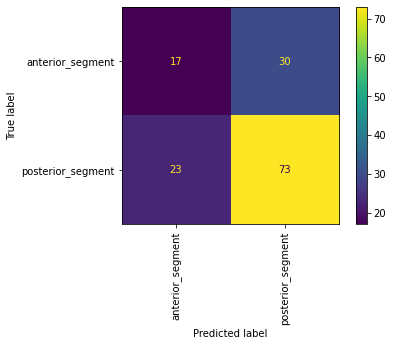

In [109]:
ada_model(X_train_f, X_test_f, y_train_f, y_test_f)